In [1]:
%cd ~/repositories/degen_discovery/operon_sr/

/Users/lucas/repositories/degen_discovery/operon_sr


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoperon.sklearn import SymbolicRegressor
import multiprocessing
import csv
from sklearn.metrics import r2_score
import string
import sys
import sympy
import esr.generation.generator

import jax
import jax.numpy as jnp


/var/folders/pg/xm7nmkzn0tq26tlbl6skh5080000gp/T/ipykernel_23274/3680485983.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


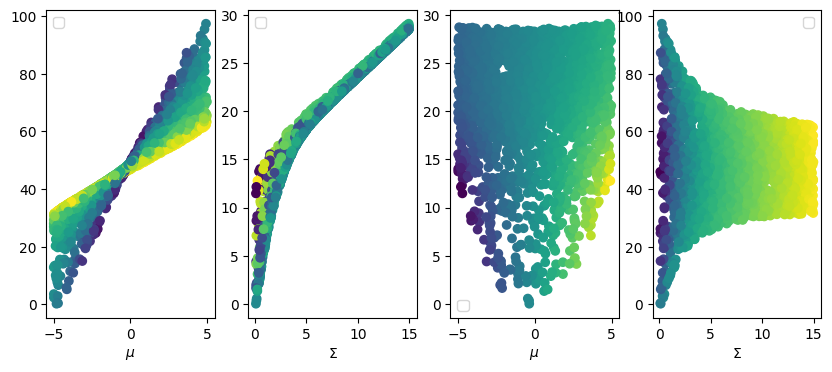

In [3]:
#datafile = np.load("flattened_coords_sr_test.npz")
#datafile = np.load("flattened_coords_sr_conn2.npz")
datafile = np.load("flattened_coords_sr_29_07_24.npz")

X = datafile["theta"] #[randidx, :] #+ np.array([5.0, 0.0])
# incorporate a mask for nonlinear regime of Var param
mask = X[:, 1] > 0.0

num_tot = mask.sum()
num_samps = 2000

skip = 10
finish = 10000

randidx = np.random.choice(num_tot, size=num_samps, replace=False)

X = datafile["theta"][mask][randidx, :] #+ np.array([5.0, 0.0])


y = datafile["eta"][mask]
# remove offset
y -= np.min(y, 0)
y = y[randidx, :]


dy = datafile["Jacobians"][mask][randidx, :, :]
dJ = datafile["deltaJ"][mask][randidx, :, :]

Fs = datafile["meanF"][mask][randidx, :]
Jbar = datafile["Jacobians"][mask][randidx, :]

#dJ = ((dJ))


fig, axs = plt.subplots(1, 4, figsize=(10,4))
axs[0].scatter(X[:,0], y[:, 0], label='', c=y[:, 1])
axs[0].set_xlabel(r"$\mu$")

axs[1].scatter(X[:,1], y[:, 1], label='', c=y[:, 0])
axs[1].set_xlabel(r"$\Sigma$")

axs[2].scatter(X[:,0], y[:, 1], label='', c=y[:, 0])
axs[2].set_xlabel(r"$\mu$")

axs[3].scatter(X[:,1], y[:, 0], label='', c=y[:, 1])
axs[3].set_xlabel(r"$\Sigma$")



for ax in axs:
    ax.legend()

X.shape, y.shape, dJ.shape

In [52]:
# Some parameters for operon
parent_dir = 'nn_results_29_07_24/'

allowed_symbols = 'add,mul,div,pow,logabs,exp,constant,variable' # exp
epsilon = 1e-4
max_length = 25 # 25
max_depth = 6
time_limit = 60 * 5 # s
objectives=['rmse', 'length']
max_evaluations=1e8
generations=1e8



In [53]:


if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

n_components = 2


for i in range(n_components):

    out_dir = parent_dir + "component_%d"%(i+1)
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
        
    reg = SymbolicRegressor(
                allowed_symbols=allowed_symbols,
                offspring_generator='basic',
                optimizer_iterations=1000,
                max_length=max_length,
                max_depth=max_depth,
                initialization_method='btc',
                n_threads=multiprocessing.cpu_count(),
                objectives = objectives,
                epsilon = epsilon,
                random_state=None,
                reinserter='keep-best',
                max_evaluations=int(max_evaluations),
                symbolic_mode=False,
                time_limit=int(time_limit),
                generations=int(generations),
                add_model_scale_term           = True,
                add_model_intercept_term       = True,

                # uncertainty=sigy,
    )

    yfit = y[:, i]

    print('Fitting')
    reg.fit(X, yfit)
    print('Done')
    print(reg.get_model_string(reg.model_, 2))
    print(reg.stats_)


    # Save Pareto front
    with open(f'{out_dir}/pareto.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        
        print(f'Outputting {len(reg.pareto_front_)} individuals on Pareto front')
        
        for i in range(len(reg.pareto_front_)):
            writer.writerow([reg.pareto_front_[i]['tree'].Length,
                            reg.pareto_front_[i]['mean_squared_error'],
                            reg.pareto_front_[i]['model'],
                            ])
            
    # Save population
    print(f'Outputting {len(reg.individuals_)} individuals in population')
    with open(f'{out_dir}/final_population.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        for ind in reg.individuals_[:reg.population_size]:
            tree = ind.Genotype
            
            # Get name but block printing to sys.stderr
            sys.stderr = open(os.devnull, 'w')
            s = reg.get_model_string(ind.Genotype, 10)
            sys.stderr = sys.__stderr__
            
            y_pred = reg.evaluate_model(tree, X)
            mse = np.mean((yfit - y_pred)**2)
            
            writer.writerow([tree.Length,
                            mse,
                            s
                            ])

Fitting
Done
(0.00 + (1.00 * ((((50.80 + (2.51 * X1)) + ((-0.27) * X2)) + (((-1.87) + (9.48 * X1)) * ((0.00 * X2) ^ (0.06 * X2)))) + ((log(abs((0.18 * X2))) * ((-0.09) * X1)) / log(abs((0.16 * X1)))))))
{'model_length': 21, 'model_complexity': 37, 'generations': 161, 'evaluation_count': 0, 'residual_evaluations': 4301945, 'jacobian_evaluations': 3567540, 'random_state': 15401915087814552226}
Outputting 22 individuals on Pareto front
Outputting 2000 individuals in population
Fitting
Done
((-0.00) + (1.00 * ((((-15.58) * exp(((-0.57) * X2))) + ((14.10 + (0.05 * X1)) + (0.96 * X2))) + ((exp(((-0.52) * X2)) + 0.03) * (8.51 ^ log(abs(((-0.68) * X1))))))))
{'model_length': 20, 'model_complexity': 30, 'generations': 134, 'evaluation_count': 0, 'residual_evaluations': 3339082, 'jacobian_evaluations': 2716712, 'random_state': 11846462185581810355}
Outputting 21 individuals on Pareto front
Outputting 2000 individuals in population


In [54]:
reg.pareto_front_[0]

{'model': '(10.235571 + (0.566363 * (2.346457 * X2)))',
 'variables': {'X2'},
 'tree': <pyoperon.pyoperon.Tree at 0x159c91370>,
 'objective_values': [1.8801614046096802, 5.0],
 'mean_squared_error': 3.5350058,
 'minimum_description_length': 5399.5693359375,
 'bayesian_information_criterion': 2548.233154296875,
 'akaike_information_criterion': 4100.59228515625}

In [55]:
import sympy

In [56]:
def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs":logAbs
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])


    def myloss(p):
        ypred = eq_jax(*p, *X.T)

        #myeq = lambda x1,x2: eq_jax(*p, x1,x2)
        myeq = lambda *args: eq_jax(*p, *args)

        # # THIS IS FOR A SINGLE COMPONENT
        yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
        Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

        result = jnp.sum((dy[:, idx, :] - Jpred)**2 / 2 / dJ[:, idx, :]**2)
        
        # NEED TO TAKE SLICE OF NUMERICAL JACOBIAN
        return result

    
    # GET ROWS OF JACOBIAN AND CHECK FLATTENING
    # def frob_loss(p):

    #     def get_jac_row(p):
            
    #         myeq = lambda *args: eq_jax(*p, *args)

    #         # THIS IS FOR A SINGLE COMPONENT
    #         yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
    #         Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

    #         return Jpred

    #     jac_row = get_jac_row(pars)
    #     Jpred = jac_row
    #     def flatten_fisher(J, F):
    #         invJ = jnp.linalg.inv(J)
            
    #         return invJ @ F[:, idx, :] @ invJ.T

    #     return jax.vmap(flatten_fisher)(Jpred, Fs)
    


    neglogL = myloss(pars)
    frobLoss = frob_loss(pars)
    #all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        #if np.any(I_ii < 0):
        #   return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML)
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, 

In [57]:
pwd

'/Users/lucas/repositories/degen_discovery/operon_sr'

In [58]:
for i in range(2):
    outdir = parent_dir + "component_%d/"%(i + 1)

    data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")[:]
    loss = np.array(data["mse"])

    print(loss.mean())
    print(loss.max())

789.700060533403
116453.76
1.2806559350000001e+32
1.2445621e+35


In [59]:
loss.std()

analysing 1 of 2 components
Best equation: (((((2.7078361511 * X1) + 49.1797981262) * ((0.2477907538 * X2) ^ ((-0.0026600766) * X2))) + ((9.2666053772 * X1) * ((0.0004872667 * X2) ^ (0.0518322513 * X2)))) + ((log(abs(((-0.1765729189) * X2))) * ((-0.0321219675) + ((-0.0979528725) * X1))) / log(abs(((-0.1600048691) * X1)))))


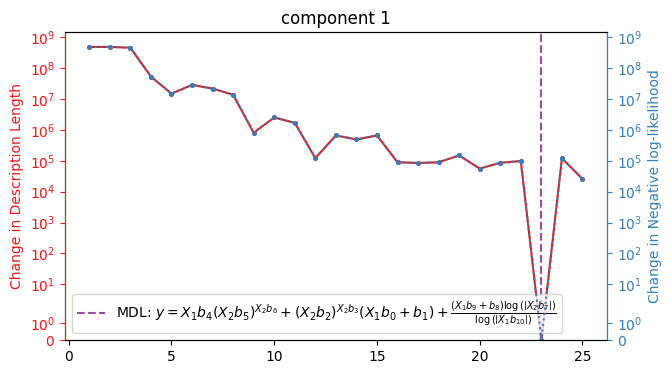

analysing 2 of 2 components
Best equation: (((((-13.5800733566) + (3.1263844967 * X2)) * exp(((-0.3713713288) * X2))) + ((12.3469495773 + (0.0466339141 * X1)) + (1.0736707449 * X2))) + (((((-0.0014508874) * X1) + (0.0027961705 * X2)) + exp(((-0.4803570509) * X2))) * (8.4912109375 ^ log(abs((0.6873981357 * X1))))))


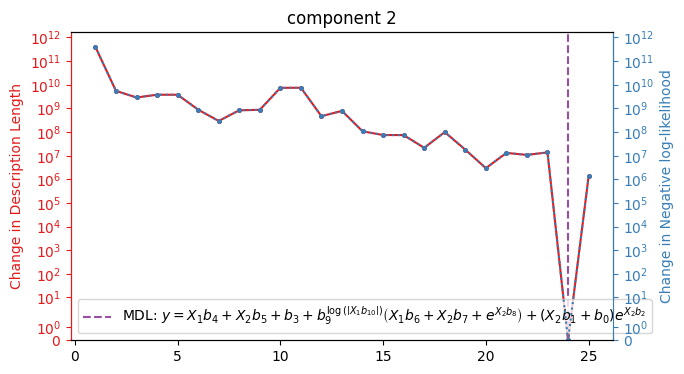

In [60]:
from tqdm import tqdm as tq


mdl_coordinates = []
mse_thresholds = 0.1
n_components = 2

for idx in range(n_components):

    
    print("analysing %d of %d components"%(idx+1, n_components))

    outdir = parent_dir + "component_%d/"%(idx + 1)
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")
    #data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")[:]
 
    #mse_threshold = mse_thresholds[idx]
    loss = np.array(data["mse"])
  #  mse_threshold = np.inf #loss.mean() - 0.1


   # mse_mask = #(loss < mse_threshold)
   # print("%d equations below MSE threshold"%(mse_mask.sum()))

    complexity = np.array(data["length"]) #[mse_mask]
    max_complexity = complexity.max()

    eqs = list(np.array(data['model'])) #[mse_mask])

    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)

    for i, eq in tq(enumerate(eqs)):
        c, all_latex[i], all_logL[i], all_DL[i] = compute_DL(eq, idx)

        
    # Only changes in DL and logL matter
    #all_DL -= np.amin(all_DL)
    #all_logL -= np.amin(all_logL)

    # get best DL model at given complexity
    pareto_DL = []
    pareto_logL = []
    pareto_latex = []
    pareto_eqs = []
    for comp in np.unique(complexity):
          mask = (complexity == comp)
          ibest_model_at_complexity = np.argmin(all_DL[mask])
          pareto_DL.append(all_DL[mask][ibest_model_at_complexity])
          pareto_logL.append(all_logL[mask][ibest_model_at_complexity])
          pareto_latex.append(np.array(all_latex)[mask][ibest_model_at_complexity])
          pareto_eqs.append(np.array(eqs)[mask][ibest_model_at_complexity])

    pareto_DL = np.array(pareto_DL)
    pareto_DL -= np.amin(pareto_DL)

    pareto_logL = np.array(pareto_logL)
    pareto_logL -= np.amin(pareto_logL)

    complexity = np.unique(complexity)
    # Print the best found equation
    ibest = np.argmin(pareto_DL)
    print('Best equation:', pareto_eqs[ibest])
    mdl_coordinates.append(pareto_eqs[ibest])

    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    ax1.plot(complexity, pareto_DL, marker='.', color=cm(0), markersize=5, )
    ax2.plot(complexity, pareto_logL, marker='.', color=cm(1), markersize=5, ls=':')

    ax1.set_ylabel('Change in Description Length')
    ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))

    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))

    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)

    #ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%pareto_latex[ibest])
    ax1.legend()
    plt.title("component %d"%(idx + 1))
    plt.show()
    #fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [61]:
compute_DL("(322.259888 + (7.156015 * log((0.1 * X2))))", 1)

(8,
 'b_{0} + b_{1} \\log{\\left(X_{2} b_{2} \\right)}',
 Array(5.1666887e+10, dtype=float32),
 Array(5.1666887e+10, dtype=float32))

In [62]:
pareto_DL, pareto_logL, pareto_latex

(array([3.97984609e+11, 5.51380983e+09, 2.89188932e+09, 3.78125636e+09,
        3.78294775e+09, 8.81689129e+08, 2.93867881e+08, 8.33069801e+08,
        8.69879401e+08, 7.40467498e+09, 7.47247300e+09, 4.67522729e+08,
        7.84884969e+08, 1.07401009e+08, 7.47461610e+07, 7.43864330e+07,
        2.14822010e+07, 9.95532330e+07, 1.79723830e+07, 2.96072150e+06,
        1.30608710e+07, 1.07811230e+07, 1.37577910e+07, 0.00000000e+00,
        1.32293700e+06]),
 array([3.97984609e+11, 5.51381001e+09, 2.89188950e+09, 3.78125654e+09,
        3.78294793e+09, 8.81689310e+08, 2.93867998e+08, 8.33069918e+08,
        8.69879518e+08, 7.40467517e+09, 7.47247318e+09, 4.67522846e+08,
        7.84885022e+08, 1.07401070e+08, 7.47462295e+07, 7.43864775e+07,
        2.14822475e+07, 9.95532855e+07, 1.79724135e+07, 2.96075450e+06,
        1.30609115e+07, 1.07811415e+07, 1.37577855e+07, 0.00000000e+00,
        1.32292050e+06]),
 ['X_{2} b_{0}',
  'e^{X_{2} b_{0}}',
  '\\left(X_{2} b_{0}\\right)^{b_{1}}',
  '\\l

In [63]:
complexity

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [64]:
mdl_coordinates

['(((((2.7078361511 * X1) + 49.1797981262) * ((0.2477907538 * X2) ^ ((-0.0026600766) * X2))) + ((9.2666053772 * X1) * ((0.0004872667 * X2) ^ (0.0518322513 * X2)))) + ((log(abs(((-0.1765729189) * X2))) * ((-0.0321219675) + ((-0.0979528725) * X1))) / log(abs(((-0.1600048691) * X1)))))',
 '(((((-13.5800733566) + (3.1263844967 * X2)) * exp(((-0.3713713288) * X2))) + ((12.3469495773 + (0.0466339141 * X1)) + (1.0736707449 * X2))) + (((((-0.0014508874) * X1) + (0.0027961705 * X2)) + exp(((-0.4803570509) * X2))) * (8.4912109375 ^ log(abs((0.6873981357 * X1))))))']

In [148]:
def check_flattening(coordinates):

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                }
    
    
    jac_rows = []
    
    for eq in coordinates:
        expr, pars = replace_floats(eq)
        expr, nodes, c = esr.generation.generator.string_to_node(
            expr, 
            basis_functions, 
            evalf=True, 
            allow_eval=True, 
            check_ops=True, 
            locs=sympy_locs
        )
        param_list = [f"b{i}" for i in range(len(pars))]
        labels = nodes.to_list(basis_functions)
        latex_expr = sympy.latex(expr)
        
        # klog(n) + \sum_i log |c_i|
        aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
        
        # Turn function into callable object
        all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
        all_x = list(sympy.symbols(all_x, real=True))
        all_b = list(sympy.symbols(param_list, real=True))
        eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])

        def get_jac_row(p):
            
            myeq = lambda *args: eq_jax(*p, *args)

            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_rows.append(get_jac_row(pars))

    Jpred = jnp.stack(jac_rows, axis=-1).transpose((0, 2, 1))
    print(Jpred.shape)
    #print(jnp.array(jac_rows).shape)
    #Jpred = jnp.stack(jac_rows, axis=-1)

    def flatten_fisher(J, F):
        invJ = jnp.linalg.inv(J)
        
        return invJ @ F @ invJ.T

    return jax.vmap(flatten_fisher)(Jpred, Fs)

        

In [149]:
mdl_flats = check_flattening(mdl_coordinates)


(2000, 2, 2)


In [150]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [151]:
def flatten_with_numerical_jacobian(J_eta, F):
    Jeta_inv = jnp.linalg.inv(J_eta)
    Q = Jeta_inv @ F @ Jeta_inv.T
    return Q


def get_evalues(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    
    return eigenvalues[eigenvalues.argsort()]


In [152]:
nn_flats = jax.vmap(flatten_with_numerical_jacobian)(Jbar, Fs)

In [153]:
evalues_nn = jax.vmap(get_evalues)(nn_flats)
evalues_mdl = jax.vmap(get_evalues)(mdl_flats)

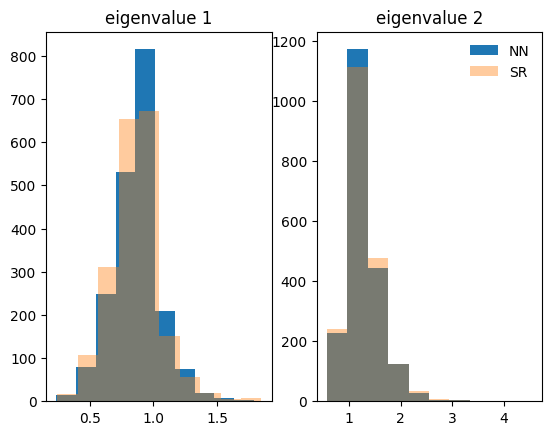

In [154]:
plt.subplot(121)
plt.title("eigenvalue 1")

plt.hist(evalues_nn[:, 0], label="NN")
plt.hist(evalues_mdl[:, 0], alpha=0.4, label="SR")

plt.subplot(122)
plt.title("eigenvalue 2")
plt.hist(evalues_nn[:, 1], label="NN")
plt.hist(evalues_mdl[:, 1], alpha=0.4, label="SR")

plt.legend(framealpha=0.0)

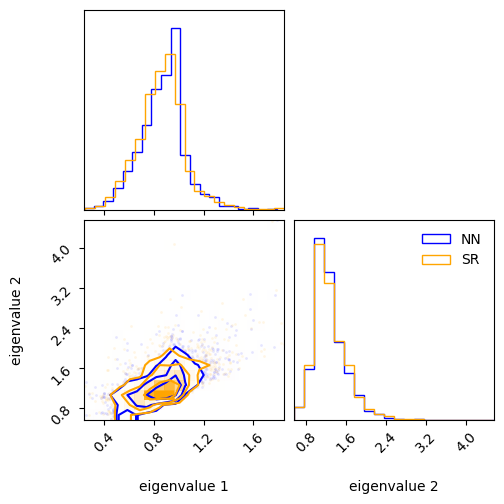

In [155]:
import corner

cols = ['eigenvalue 1', 'eigenvalue 2']

figure = corner.corner(np.array(evalues_nn), color="blue", labels=cols, hist_kwargs=dict(label="NN"))
figure = corner.corner(np.array(evalues_mdl), color="orange", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR"))
plt.legend(framealpha=0.0)


In [156]:
nn_flats.shape

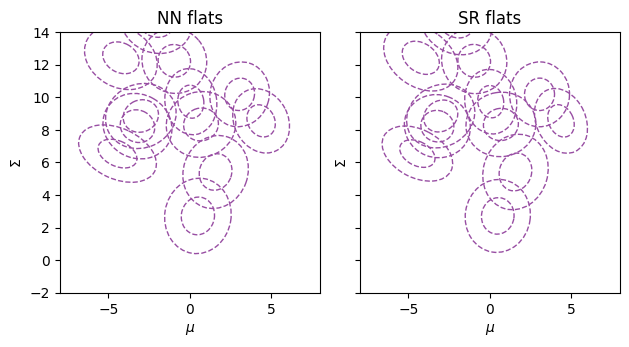

In [157]:
# plot a smattering of fishers

randidx = np.random.choice(num_samps, size=(12), replace=False)


_, axs = plt.subplots(1, 2, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu$")
ax.set_xlim(-8, 8)
ax.set_ylim(-2, 14)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu$")
ax.set_xlim(-8, 8)
ax.set_ylim(-2, 14)
ax.set_title("SR flats")

ax.set_box_aspect(1)


#plt.legend()

plt.tight_layout()

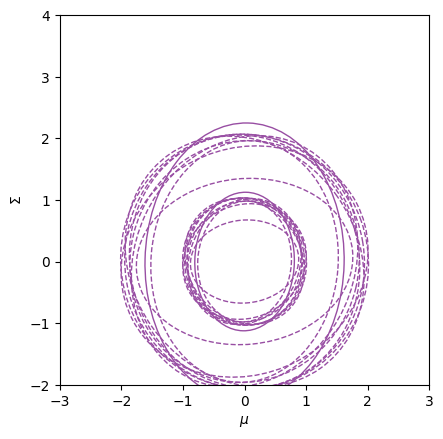

In [158]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu$")
ax.set_xlim(-3, 3)
ax.set_ylim(-2, 4)
ax.set_box_aspect(1)
#plt.legend()